### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cpu device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-05 22:15:48--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.007s  

2024-11-05 22:15:48 (35.2 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [6]:
next(generate_chunk())

array([[83, 59, 47, ..., 50, 67,  0],
       [83, 58, 45, ..., 45, 61, 50],
       [83,  2,  7, ..., 58, 13,  0],
       ...,
       [83,  1, 61, ..., 53,  1, 55],
       [83, 56, 53, ..., 48,  1, 59],
       [83, 52, 45, ..., 62, 50, 61]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [44]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(self.__class__, self).__init__()

        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=hidden_size)
        self.W_hh = nn.Linear(hidden_size, hidden_size)
        self.W_xh = nn.Linear(hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.W_ho = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        x_embed = self.embedding(x)
        h_new = self.tanh(self.W_xh(x_embed) + self.W_hh(h))
        output = self.W_ho(h_new)

        return output, h_new

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [45]:
def rnn_loop(rnn_model, batch_data, batch_labels, loss_func, optimizer):
    batch_size, seq_length = batch_data.size()
    hidden_state = rnn_model.initial_state(batch_size)

    optimizer.zero_grad()

    outputs = []
    for t in range(seq_length):
        x_t = batch_data[:, t]
        output, hidden_state = rnn_model(x_t, hidden_state)
        outputs.append(output)

    outputs = torch.stack(outputs, dim=1)

    outputs = outputs.reshape(-1, outputs.size(-1))
    targets = batch_labels.reshape(-1)

    loss = loss_func(outputs, targets)
    loss.backward()
    optimizer.step()

    return loss.item()

In [46]:
rnn = VanillaRNN(input_size=num_tokens, hidden_size=batch_size, output_size=num_tokens)
optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-4)
loss_func = nn.CrossEntropyLoss()
history = []
epochs = 1000

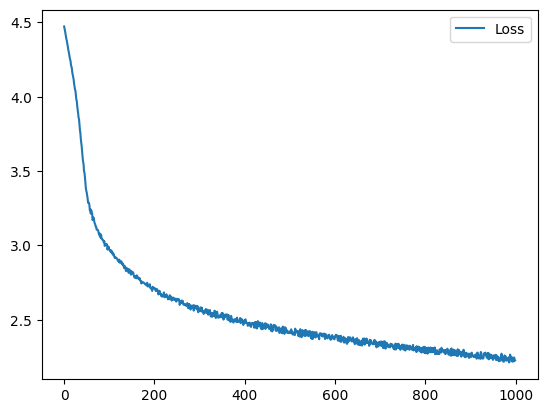

Epoch 1000/1000, Loss: 2.2278


In [47]:
for epoch in range(epochs):
    batch_data = torch.tensor(next(generate_chunk()), dtype=torch.long)

    input_sequence = batch_data[:, :-1]
    target_sequence = batch_data[:, 1:]

    loss = rnn_loop(rnn, input_sequence, target_sequence, loss_func, optimizer)

    history.append(loss)

    if (epoch + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='Loss')
        plt.legend()
        plt.show()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}')

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

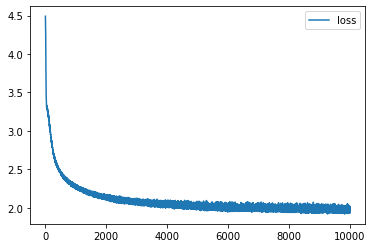

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [64]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any
    hid_state = char_rnn.initial_state(batch_size=1)
    for i in range(len(x_sequence[0]) - 1):
        _, hid_state = char_rnn(x_sequence[:, i], hid_state)

    # your code here
    for _ in range(max_length - len(x_sequence[0]) + 1):
        logits_next, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0]

        assert len(p_next) == num_tokens, f"Expected p_next of length {num_tokens}, but got {len(p_next)}"

        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [65]:
print(generate_sample(rnn, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правили пямил дно стальвецу он ни речет, на. скоюбоменскогом бося
соберь gотратый вахов тон преиталиской всума шасных ппился,
правой,
ват михоинь!
и пли онсам и мотеруг,
еще маковранью не годве душенье лимный ежна так бречета полине всё ечалось. ихать им них на придритье мне любодок,
огракой
а взрободыны,
что он, леннуший чивстом мнок.
и не светь. всё струча,
и моталься не моем одалтами горуг. что в тоб воины верить
и сней. и жномий на подушь мое строзю унерь я на породну


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [66]:
seed_phrase = ' мой дядя самых честных правил'

In [67]:
generated_phrases = [generate_sample(rnn,
                                     seed_phrase,
                                     max_length=500,
                                     temperature=1,).replace('<sos>', '') for _ in range(10)]# your code here

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [68]:
for phrase in generated_phrases:
    print(len(phrase))

500
500
500
500
500
500
500
500
500
500


In [69]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!